#### Steps to take include
* Import libraries to be used
* Import data
* Document each stage you do
* Clean data
* Visualize raw data
* Process data
* Model data
* Deploy data
* Predict test and validation data

#                                    Predicting Announcement of Disaster using Tweets

### Import Data

In [144]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

In [146]:
# check contents of train and test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(train.shape)
train.head(10)

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [147]:
# check contents of train data

print(test.shape)
test.head(10)

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


### Prepare Data

Text(0.5, 1.0, 'Bar Plot of Labels')

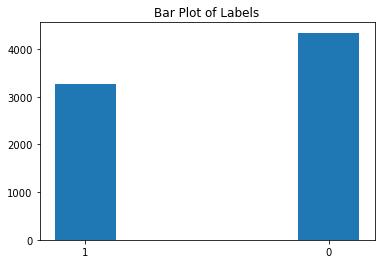

In [149]:
# plot data
import matplotlib.pyplot as plt

# 
one = [x for x in train['target'] if x == 1]
zero = [y for y in train['target'] if y == 0]

heights = [len(one), len(zero)]
target = ['1', '0']


fig, ax = plt.subplots()
ax.bar(target, heights, width=0.25)
ax.set_title("Bar Plot of Labels")

Get unique keywords to understand the type of disasters contained in the data. 

In [150]:
# plot keyword

# loop through keyword to find unique keywords
def keywords(df):
    
    unique = []
    for x in df:
        if x not in unique:
            unique.append(x)
    return unique

unique_keywords = keywords(train['keyword']) 
print(unique_keywords)

[nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging', 'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse', 'buildings%20burning', 'buildings%20on%20fire', 'burned', 'burning', 'burning%20buildings', 'bush%20fires', 'casualties', 'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided', 'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged', 'demolish', 'demolished', 'demolition', 'derail', 'derailed', 'derailment', 'desolate', 'desolation', 'destroy', 'destroyed', 'destruction', 'detonate', 'deto

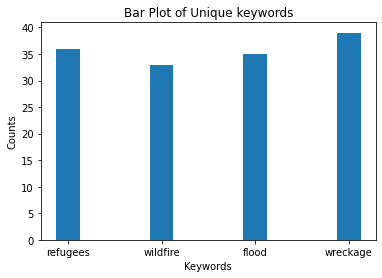

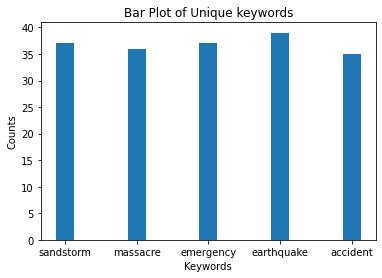

In [154]:
# plot some keywords

def counts(keyword):
    content = []
    
    for x in keyword:
        x = len(x)
        content.append(x)
        
    return content

def bar_plots(df, unique):
    
    heights = []
    
    for y in unique:
        container = []
        for x in df['keyword']: 
            if x == y:
                container.append(y)
        heights.append(container) 
        
    count = counts(heights)
        
    fig, ax = plt.subplots()
    ax.bar(unique, count, width=0.25)
    ax.set_title("Bar Plot of Unique keywords")
    ax.set_xlabel("Keywords")
    ax.set_ylabel("Counts")
               
bar_plots(train, ['refugees', 'wildfire', 'flood', 'wreckage'])
bar_plots(train, ['sandstorm', 'massacre', 'emergency', 'earthquake', 'accident', 'massacre'])

In [155]:
# Clean data, check and remove empty records

def empty_null_check(df, indexes):
    
    empty = []
    isnull = []
    
    for y in indexes:
        if df[df[y] == ''].index is not []:
            empty.append(True)
        if True in list(pd.isna(df[y])):
            isnull.append(True)
        else: 
            isnull.append(False)
            
    return empty, isnull

empty_null_check(train, ['id', 'target', 'location', 'keyword', 'text'])

([True, True, True, True, True], [False, False, True, True, False])

In [156]:
# Decide if null values will be removed

null_vals_location = []
null_vals_keyword = []

for x in range(0, len(train)):
    if pd.isnull(train.loc[x, 'location']):
        null_vals_location.append(True)
    if pd.isnull(train.loc[x, 'keyword']):
        null_vals_keyword.append(True)

print(len(null_vals_location))
print(len(null_vals_keyword))

2533
61


Since the location contains large number of null values, decided to not remove the rows containing null values. They do not affect the text and target and they will not be used for the modelling. They can only be used if one wants to predict a particular kind of emergency (keyword) in a particular location

In [157]:
# Drop id, keyword and location columns

df = train.drop(columns=['id', 'keyword', 'location'], axis=0)
df.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


### Cleaning of data

In [158]:
X_train = df['text']
y = df['target']

In [159]:
# for competition test set

X_test = test.drop(columns=['id','keyword', 'location'])
X_test = X_test['text']

In [160]:
# import libraries for cleaning  and processing tweets text 
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import *
from bs4 import BeautifulSoup
nltk.download("stopwords")
stemmer = PorterStemmer()

# clean, process and tokenize words in texts
def texts_to_words(tweet):

    # for each tweet, remove HTML tags if present
    tweet_text = BeautifulSoup(tweet, "html.parser").get_text()
    
    # convert to texts lowercase and remove urls
    tweet_text = re.sub(r"http\S+", " ", tweet.lower())
    
    tweet_text = re.sub(r"[^a-zA-Z0-9]", " ", tweet_text.lower())
      
    words = tweet_text.split()
    # if word is a stopword, remove
    words = [word for word in words if word not in stopwords.words("english")]
    # stem the words
    words = [PorterStemmer().stem(word) for word in words]
    # remove word less than 3 letters
    words = [word for word in words if len(word) > 3] 
    
    
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
# sample
texts_to_words(X_train[700])

['bekah', 'thank', 'sweat', 'bullet', 'everi', 'time', 'blaze', 'beat']

In [164]:
# apply texts_to_words function above to train and validation sets, save in cache
import pickle
import os

# create the cache directory
cache_dir = os.path.join('../cache', "capstone_project" )

# ensure it exists
os.makedirs(cache_dir, exist_ok=True)

In [165]:
# use the texts_to_words and process text, save in cache directory

def process_texts(train_text, test_text, train_label,
                  cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    
    cache_data = None
    # check if cache file is None by reading it 
    if cache_file is not None:
        try:
            with open(os.path.join(cach_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read processed data from cache", cache_file)
        except:
            pass
    
    
    if cache_data is None:
             
            # process each text in train, test and validation sets.
        
            train_words = [texts_to_words(text) for text in train_text]
            test_words = [texts_to_words(text) for text in test_text]
            
            # if cache file is not write the processed data into it
            
            if cache_file is not None:
                cache_data = dict(train_words=train_words, test_words=test_words,
                                 train_label=train_label)
                with open(os.path.join(cache_dir, cache_file), "wb") as f:
                    pickle.dump(cache_data, f)
                print("Wrote processed data to cache", cache_file)
                    
    else:
        train_words, test_words, train_label = (cache_data['train_words'],
                                        cache_data['test_words'], cache_data['train_label'])    
                
    
    return train_words, test_words, train_label

In [166]:
X_train, X_test, y_tr = process_texts(X_train, X_test, y)

Wrote processed data to cache preprocessed_data.pkl


In [167]:
X_train[50]

['deputi', 'shot', 'brighton', 'home', 'ablaz']

In [168]:
X_test[1000]

['demolish', 'palestinian', 'villag', 'come', 'back', 'life', 'wagingnv']

### Bag of Words Extraction

In [170]:
# Extract meaning by using tfidf vectorizer
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer


def extract_words_features(train_words, test_words,vocabulary_size=5000):
        
    vectorizer = TfidfVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)

    train_features = vectorizer.fit_transform(train_words).toarray()
    test_features = vectorizer.transform(test_words).toarray()
    
    # get vocabulary in both train and test sets
    vocabulary = vectorizer.vocabulary_

            
    return vocabulary

In [171]:
vocabulary = extract_words_features(X_train, X_test)

In [172]:
# prepare data for uploading to s3
capstone_data_dir = "../data/capstone"

if not os.path.exists(capstone_data_dir):
    os.makedirs(capstone_data_dir)

with open(os.path.join(capstone_data_dir, 'vocabulary_dict.pkl'), "wb") as f:
    pickle.dump(vocabulary, f)

Change and pad each sentence in the texts to get the length or number of words and count of words (occurance in created dictionary) in the text from the vocabulary dictionary.

In [173]:
def convert_and_pad(vocabulary_dict, sentence, pad=100):
    NOWORD = 0 # used to represent no word category
    INFREQ = 1 # used 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in vocabulary_dict:
            working_sentence[word_index] = vocabulary_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(vocabulary_dict, data, pad=100):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(vocabulary_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [174]:
train_X, train_X_len = convert_and_pad_data(vocabulary, X_train)
test_X, test_X_len = convert_and_pad_data(vocabulary, X_test)

In [175]:
train_X[1000]

array([3128, 1264, 4275,  516, 2564, 4230,    1,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [176]:
test_X[500]

array([1953, 2516,   70,  209,  303,  521, 4933, 2782,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

Define and slit the data sets

In [177]:
y = pd.DataFrame(y_tr)
X = pd.DataFrame(train_X)
X_train_len = pd.DataFrame(train_X_len)
X_test = pd.DataFrame(test_X)

In [178]:
# split data to train and validation sets
X_train = pd.DataFrame(X[1000:])
X_len = pd.DataFrame(X_train_len[1000:])

y_val= pd.DataFrame(y[:1000])

y_train = pd.DataFrame(y[1000:])
X_val = pd.DataFrame(X[:1000])
X_val_len = pd.DataFrame(X_train_len[:1000])

In [179]:
# concat the training set and send to capstone data directory

pd.concat([y_train, X_len, X_train], axis=1).to_csv(os.path.join(capstone_data_dir, 'training.csv'), header=False, index=False)

In [180]:
# get the sagemaker session
session = sagemaker.Session()
role = sagemaker.get_execution_role()
prefix="capstone_project"

bucket = sagemaker.Session().default_bucket()
output_path = 's3://{}/{}/output'.format(bucket, prefix)

### Modelling

This stage, I uploaded the input data to s3 bucket, then created a PyTorch estimator which accepts parameters such as entry point, and output path. The entry point is where the classifier model is invoked, the parameters are added and the data is converted and loaded for the training. Afterwards, the model estimator is fitted with the input data and trained.

In [181]:
# upload directory to s3

input_data = session.upload_data(capstone_data_dir, bucket=bucket, key_prefix=prefix)

In [196]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='train.py',
                    source_dir="train",
                   role=role,
                   output_path=output_path,
                   framework_version='1.0',
                   train_instance_count=1,
                   py_version='py3',
                   train_instance_type='ml.c4.xlarge',
                   sagemaker_session=session,
                   hyperparameters={
                       'hidden_dim': 128,
                       'embedding_dim': 64,
                       'epochs': 50
                   })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [197]:
%%time

estimator.fit({'training': input_data})

2021-04-02 10:54:20 Starting - Starting the training job...
2021-04-02 10:54:22 Starting - Launching requested ML instancesProfilerReport-1617360860: InProgress
......
2021-04-02 10:55:47 Starting - Preparing the instances for training......
2021-04-02 10:56:47 Downloading - Downloading input data
2021-04-02 10:56:47 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-04-02 10:57:01,632 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-04-02 10:57:01,635 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-04-02 10:57:01,648 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-04-02 10:57:01,649 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-04-02 10:57:02,130 sagemaker-containers INFO     Module train does not provide a setup.py. 
Gener

### Deploy Model

In [198]:
# deploy the model

estimator_deploy = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge') 

-------------!

In [199]:
def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, estimator_deploy.predict(array))
    
    return predictions

In [200]:
val_X = pd.concat([X_val_len, pd.DataFrame(X_val)], axis=1)

In [201]:
predictions = predict(val_X.values)
y_val_predict = [round(num) for num in predictions]

### Evaluate Model

In [202]:
# check the accuracy and auc score
from sklearn.metrics import accuracy_score, roc_auc_score


print('\n Accuracy Score')
print(accuracy_score(y_val, y_val_predict))
print('\n AUC Score')
print(roc_auc_score(y_val, y_val_predict))


 Accuracy Score
0.735

 AUC Score
0.7090812595824979


In [189]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [203]:
predictions_test = predict(test_X)
y_test_predict = [round(num) for num in predictions_test]

In [221]:
# send test predictions to capstone data folder

pd.concat([test['id'], pd.DataFrame(np.array(y_test_predict), columns=["predictions"])], axis=1).to_csv(os.path.join(capstone_data_dir, 'test-predicts.csv'), header=True, index=False)

In [205]:
# delete enpoint

estimator_deploy.delete_endpoint()